In [1]:
# load dataset
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import simplejson as json

df = pd.read_csv("/users/akuppam/documents/Hprog/Py/rnb1015_2.csv")
df.head(5)

,date,region,marketing,visits,br,inq,gb,cb,nb,ss,ts,listings
0,1/1/16,AMR,NotPaid,1256288,6043,66022,6071,571,5500,485968.08000,144695.894200,10242216
1,1/1/16,AMR,Paid,189297,1092,11806,743,2,741,0.00000,14138.809600,2133795
2,1/1/16,UK,NotPaid,201797,435,9662,436,33,403,72698.92472,8317.105056,3561696
3,1/1/16,UK,Paid,55934,88,2749,61,1,60,0.00000,815.336426,890424
4,1/1/16,CE,NotPaid,200786,573,9250,435,31,404,40490.73159,12016.782410,3062480


In [2]:
df_SoEu = df.loc[(df['region'] == 'SoEu') & (df['marketing'] == 'Paid')]

In [3]:
df_SoEu.describe()

,visits,br,inq,gb,cb,nb,ss,ts,listings
count,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1.019000e+03
mean,74977.201178,126.513248,1868.298332,70.830226,10.796860,60.033366,261.557956,4857.805555,1.258473e+06
std,30731.119884,58.362415,1375.082938,32.398605,8.295438,27.988892,569.734346,3724.801936,2.592105e+05
min,13699.000000,12.000000,227.000000,7.000000,0.000000,-55.000000,0.000000,-13107.894210,1.688280e+05
25%,53730.000000,77.000000,755.000000,43.500000,5.000000,38.000000,0.000000,1778.225913,1.116910e+06
50%,70230.000000,126.000000,1305.000000,71.000000,10.000000,59.000000,0.000000,3805.584926,1.294740e+06
75%,93718.500000,171.000000,2777.000000,96.000000,15.000000,80.000000,0.000000,7335.610319,1.429740e+06
max,189138.000000,282.000000,7011.000000,168.000000,145.000000,148.000000,3725.201180,18210.860160,1.710540e+06


In [ ]:
import warnings
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	history = [x for x in X]
	# make predictions
	predictions = list()
	for t in range(len(X)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(transparams=True)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(X[t])
	# calculate out of sample error
	error = mean_squared_error(X, predictions)
	mape = np.mean(abs((X-predictions)/X))
	return error
	return mape

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_params = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_params = mse, order
					print('ARIMA %s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA %s MSE=%.3f' % (best_params, best_score))
	model_params = [p,d,q]
	print("best order =", model_params)
	with open('model_params.json','w') as out_params:
		json.dump(model_params, out_params)

# load dataset
series = df_SoEu['nb']

# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

# select the best set of p,d,q
with open('model_params.json') as json_file:
    out_params = json.load(json_file)
out_params
p = out_params[0]
d = out_params[1]
q = out_params[2]

# apply model
model = ARIMA(series, order=(p,d,q))
model_fit = model.fit(transparams=True)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
#pyplot.show()
residuals.plot(kind='kde')
#pyplot.show()
plt.savefig('residuals.png')
print(residuals.describe())

# Plot 'real' vs. 'predictions'
import numpy as np
X = series.values
history = [x for x in X]
predictions = list()
for t in range(len(X)):
	model = ARIMA(history, order=(p,d,q))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = X[t]
	history.append(obs)
# plot
pyplot.plot(X)
pyplot.plot(predictions, color='red')
#pyplot.show()
pyplot.savefig('real vs predictions.png')

# compute MAPE
pf = pd.DataFrame(predictions)
xf = pd.DataFrame(X)
dff = pd.concat([pf,xf],axis=1)
dff.columns = ['predict_arima', 'real']
dff['abspctdiff'] = abs(dff['predict_arima']-dff['real'])/dff['real']
mape_arima = np.mean(dff['abspctdiff'])
print("mape_arima = ", mape_arima)

# Get forecast 442 steps ahead in future (10/15/2018 to 12/31/2019)
pred_forecast = model_fit.forecast(steps=442)
pdf = pd.DataFrame(pred_forecast[0])
pdf.to_csv("forecasts_arima.csv")

ARIMA (0, 0, 0) MSE=783.119
ARIMA (0, 0, 1) MSE=437.195
ARIMA (0, 0, 2) MSE=345.503
ARIMA (0, 0, 3) MSE=307.029
ARIMA (0, 1, 0) MSE=271.936
ARIMA (0, 1, 1) MSE=215.084
ARIMA (0, 1, 2) MSE=207.551
ARIMA (0, 1, 3) MSE=207.686
ARIMA (0, 2, 0) MSE=720.660
ARIMA (0, 2, 1) MSE=272.357
ARIMA (1, 0, 0) MSE=248.551
ARIMA (1, 0, 1) MSE=213.155
ARIMA (1, 0, 2) MSE=206.163
ARIMA (1, 0, 3) MSE=206.339
ARIMA (1, 1, 0) MSE=243.680
ARIMA (1, 1, 1) MSE=207.801
ARIMA (1, 1, 2) MSE=207.618
ARIMA (1, 1, 3) MSE=209.073
ARIMA (1, 2, 0) MSE=474.828
ARIMA (2, 0, 0) MSE=231.997
ARIMA (2, 0, 1) MSE=206.461
ARIMA (2, 0, 2) MSE=206.247
ARIMA (2, 0, 3) MSE=206.999
ARIMA (2, 1, 0) MSE=231.158
ARIMA (2, 1, 1) MSE=207.436
ARIMA (2, 1, 2) MSE=202.193
ARIMA (2, 1, 3) MSE=180.801
ARIMA (2, 2, 0) MSE=392.408
ARIMA (3, 0, 0) MSE=223.889
ARIMA (3, 0, 1) MSE=206.029
ARIMA (3, 0, 2) MSE=199.695


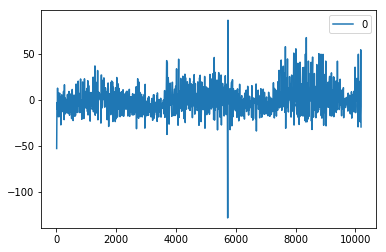

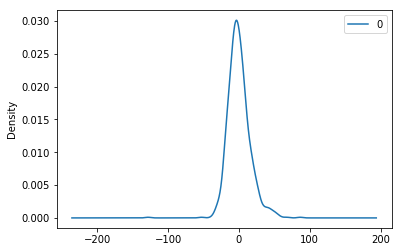

                 0
count  1019.000000
mean      0.043059
std      15.708071
min    -128.255211
25%      -9.700935
50%      -1.630405
75%       8.046936
max      86.463635


In [46]:
from matplotlib import pyplot
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

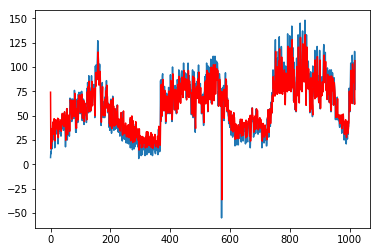

0.2442556403368571

In [23]:
# Plot 'real' vs. 'predictions'
# --------------------------------
import numpy as np
X = series.values
history = [x for x in X]
predictions = list()
for t in range(len(X)):
	model = ARIMA(history, order=(p,d,q))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = X[t]
	history.append(obs)
# plot
pyplot.plot(X)
pyplot.plot(predictions, color='red')
pyplot.show()

pf = pd.DataFrame(predictions)
xf = pd.DataFrame(X)
dff = pd.concat([pf,xf],axis=1)
dff.columns = ['predict_arima', 'real']
dff['abspctdiff'] = abs(dff['predict_arima']-dff['real'])/dff['real']
mape_arima = np.mean(dff['abspctdiff'])
mape_arima

In [24]:
# Get forecast 442 steps ahead in future (10/15/2018 to 12/31/2019)
pred_forecast = model_fit.forecast(steps=442)
pdf = pd.DataFrame(pred_forecast[0])
pdf.to_csv("forecasts_arima.csv")

In [63]:
pdf.head()

,0
0,98.541165
1,94.332612
2,93.338918
3,93.125232
4,93.100795


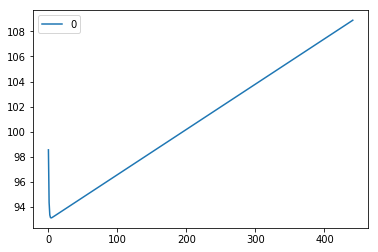

In [64]:
pdf.plot()

In [48]:
residuals = pd.DataFrame(model_fit.resid)

In [47]:
model_fit.resid

7       -52.862266
17       -2.991086
27       -9.970575
37       12.689254
47       -7.738958
57      -18.249213
67        7.539680
77        4.090957
87      -18.378276
97        1.070446
107       7.261042
117      -8.697936
127       2.281553
137      -5.697936
147     -27.208191
157       3.709765
167      -0.419298
177       5.431128
187      -6.868021
197      -4.548362
207       0.281553
217      -4.038106
227     -13.208191
237       9.090957
247      -8.527851
257     -21.548362
267      16.390106
277     -15.697936
287       2.090957
297      -7.718447
           ...    
9897     -9.929554
9907      2.390106
9917      5.920872
9927    -11.208191
9937    -11.568872
9947      9.240532
9957    -13.208191
9967      2.090957
9977     -2.718447
9987     35.451638
9997      3.084959
10007   -13.915041
10017    -6.806488
10027    20.002916
10037    12.574704
10047    23.275555
10057    -1.492827
10067     9.976407
10077     6.656747
10087   -29.343253
10097    49.533682
10107     0.